In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import starmap

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from shapes import plot_result
from datasets import RectangleDataset
from single_rectangle import SimpleModel
from single_rectangle import plot_performance, intersection_over_union

# import importlib
# importlib.reload(plot_performance)

In [2]:
data_n_size = 50000
data_xy_size = 8
test_n_size = 10000

batch_size = 16

full_data = RectangleDataset(data_n_size, data_xy_size)
test_data = RectangleDataset(test_n_size, data_xy_size)

train_data, valid_data = train_test_split(full_data, test_size=0.2)

train_dataloader = DataLoader(train_data, batch_size=batch_size,)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size,)
test_dataloader = DataLoader(test_data, batch_size=batch_size,)

40000 10000 10000


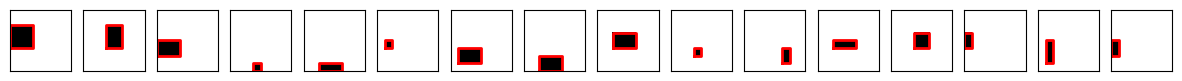

In [3]:
example_data, example_targets = next(iter(train_dataloader))
example_testdata, example_testtarget = next(iter(test_dataloader))

fig, axs = plt.subplots(ncols=batch_size, figsize=(15, 15*batch_size))
for img, res, ax in zip(example_data, example_targets, axs):
    plot_result(np.squeeze(img), res, ax=ax)

print(len(train_data), len(valid_data), len(test_data))

In [4]:
model = SimpleModel(data_xy_size ** 2)

epochs = 50
optimizer = optim.SGD(model.parameters(), lr=0.1)
# optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

total_loss = []
total_valid_loss = []
total_iou = []
total_valid_iou = []
for epoch in range(epochs):
    model.train()

    train_loss, train_iou = 0.0, 0.0
    for data, target in train_dataloader:

        data, target = data.float(), target.float()
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()


        train_iou += np.mean(list(starmap(intersection_over_union, zip(model(data), target))))

    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    total_loss.append(train_loss)
    total_iou.append(train_iou)

    if epoch % 5 == 0:
        model.eval()
        valid_loss, valid_iou = 0.0, 0.0

        for data, target in valid_dataloader:
            data, target = data.float(), target.float()

            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()

            valid_iou += np.mean(list(starmap(intersection_over_union, zip(model(data), target))))



        valid_loss /= len(valid_dataloader)
        valid_iou /= len(valid_dataloader)
        total_valid_loss.append(valid_loss)
        total_valid_iou.append(valid_iou)

        print(f"Epoch {epoch}/{epochs}:\t\t train loss: {train_loss:.5f} \t train IoU: {train_iou:.3f} \t validation loss: {valid_loss:.5f} \t validation IoU: {valid_iou:.3f}")



Epoch 0/50:		 train loss: 0.17919 	 train IoU: 0.551 	 validation loss: 0.01265 	 validation IoU: 0.797
Epoch 5/50:		 train loss: 0.02686 	 train IoU: 0.732 	 validation loss: 0.00649 	 validation IoU: 0.849
Epoch 10/50:		 train loss: 0.02040 	 train IoU: 0.759 	 validation loss: 0.00617 	 validation IoU: 0.884
Epoch 15/50:		 train loss: 0.01777 	 train IoU: 0.773 	 validation loss: 0.00517 	 validation IoU: 0.895
Epoch 20/50:		 train loss: 0.01611 	 train IoU: 0.781 	 validation loss: 0.00435 	 validation IoU: 0.902
Epoch 25/50:		 train loss: 0.01503 	 train IoU: 0.787 	 validation loss: 0.00303 	 validation IoU: 0.916
Epoch 30/50:		 train loss: 0.01408 	 train IoU: 0.792 	 validation loss: 0.00292 	 validation IoU: 0.921
Epoch 35/50:		 train loss: 0.01343 	 train IoU: 0.796 	 validation loss: 0.00311 	 validation IoU: 0.918
Epoch 40/50:		 train loss: 0.01315 	 train IoU: 0.799 	 validation loss: 0.00184 	 validation IoU: 0.934
Epoch 45/50:		 train loss: 0.01255 	 train IoU: 0.801 	 v

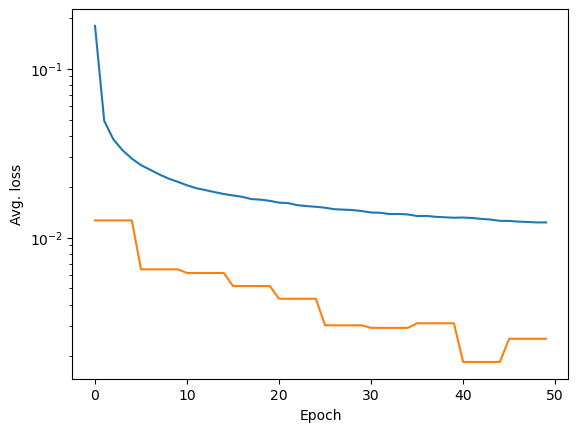

In [5]:
plt.semilogy(total_loss)
plt.semilogy([val for val in total_valid_loss for _ in (0, 1, 2, 3, 4,)])
plt.xlabel("Epoch")
plt.ylabel("Avg. loss");

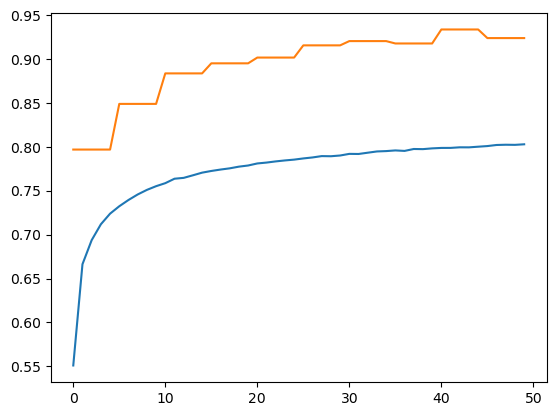

In [6]:
plt.plot(total_iou)
plt.plot([val for val in total_valid_iou for _ in (0, 1, 2, 3, 4)])

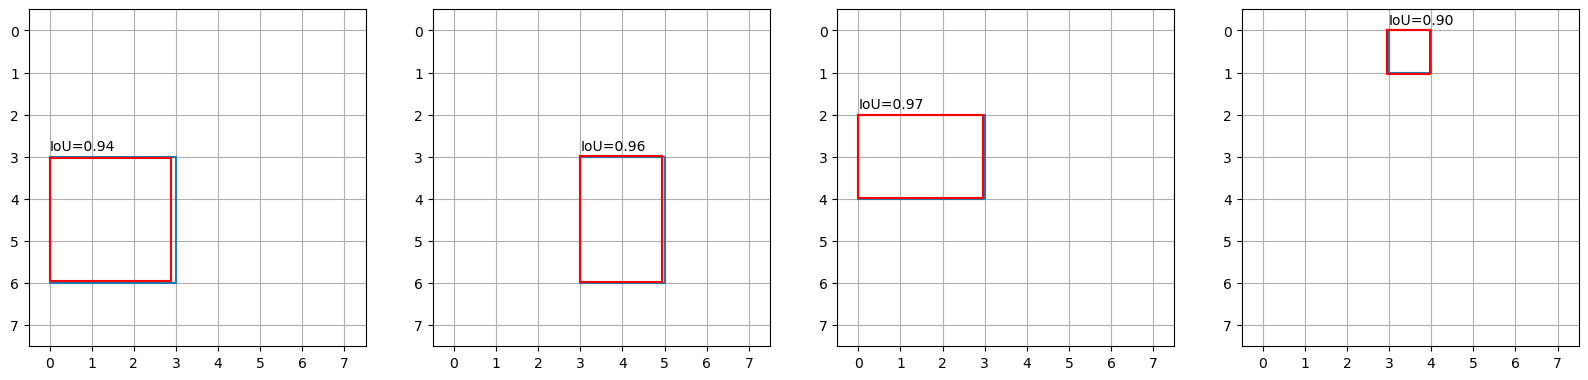

In [17]:
model.eval()
slice = np.s_[:4]
fig = plot_performance(model, example_data[slice], example_targets[slice], )
fig.savefig("plots/single_rectangle_testset_0_4.png", facecolor='white')

In [18]:
# slice = np.s_[4:8]
# fig = plot_performance(model, example_data[slice], example_targets[slice], )
# fig.savefig("plots/single_rectangle_testset_0_4.png", facecolor='white')